# Applying the MaxFilter after identifying bad sensors

## Introduction
The aim of this section is to demonstrate the application of the 'Maxwell filtering' also referred to as signal-space separation (SSS). The implementation termed MaxFilter serves to reduce artifacts from both environmental sources and sensor noise. The procedure also performs some fine-tuning and reduces the cross-talk between co-located sensors. Prior to applying the MaxFilter algorithm it is advisable to remove 'bad' sensors, i.e. sensors that are flat or have excessive artifacts. If this is not done, it might result in the artifacts from faulty sensors being distributed to other sensors.

Specifically, the SSS is a technique derived from the physics of electromagnetism defined by the Maxwell equations (Taulu and Kajola 2005; Taulu and Simola 2006). The algorithm separates the measured signal into components attributable to sources respectively inside and outside the MEG sensor array. As the internal and external components are linearly independent, it is possible to suppress the contribution from the external components and thus reduce environmental noise sources. The procedure also omits the higher-order components dominated by  noise.

## Preparation
First load the relevant Python modules:

In [1]:
# mount the drive (you'll have to click through the popup to allow it)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install openneuro-py
!pip install --upgrade mne-bids[full]

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.6/163.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 76.6 MB/s eta 0:00:00


In [2]:
import os.path as op
import os
import sys
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids
import matplotlib.pyplot as plt
import scipy

### File overview
The chapter relies on the input files:

~~~
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_meg.fif
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_acq-calibration_meg.dat
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_acq-crosstalk_meg.fif
~~~
and generates the output files
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
~~~

Define path to the local data and then define the file names:

In [3]:
bids_root = 'drive/MyDrive/GripS MEG/Data/COGITATE/'

subject = 'CB069'
session = '1'
task = 'dur'  # name of the task
run = '01'  # we have two runs for this subject, let's look at run = 1
suffix = 'meg'

bids_path = BIDSPath(subject=subject, session=session, task=task, run=run, suffix=suffix, root=bids_root)

deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix='meg', root=deriv_root).mkdir()

deriv_fname = bids_path.basename.replace('meg', 'sss') # output filename
deriv_file_1 = op.join(deriv_path.directory, deriv_fname)+'.fif'
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')

Now define the calibration and cross-talk files. These files contains site-specific information relating to sensor orientation and calibration. If you cannot find them, please ask your local experts. The crosstalk compensation file containes parameters used to reduce interference between co-located magnetometer and paired gradiometer sensor units. The calibration file contains information specific to the local static magnetic fields and gradients. Note that the calibration file will be specific to the position of the MEG system (the angle of the gantry). In this case the gantry angle was 68 degrees (see 'A first look at the data').

In [4]:
deriv_file_1

'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_raw_sss.fif'

In [5]:
crosstalk_file = bids_path.meg_crosstalk_fpath
calibration_file = bids_path.meg_calibration_fpath
print(crosstalk_file)
print(calibration_file)

drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_acq-crosstalk_meg.fif
drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_acq-calibration_meg.dat


Now read the raw data:

In [6]:
raw1 = read_raw_bids(bids_path=bids_path,
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_meg.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 9000 ... 511999 =      9.000 ...   511.999 secs
Ready.


<ipython-input-6-04ba28807a46>:1: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw1 = read_raw_bids(bids_path=bids_path,


Reading 0 ... 502999  =      0.000 ...   502.999 secs...
Reading events from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_events.tsv.
Reading channel info from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_channels.tsv.


<ipython-input-6-04ba28807a46>:1: RuntimeWarning: Omitted 815 annotation(s) that were outside data range.
  raw1 = read_raw_bids(bids_path=bids_path,
<ipython-input-6-04ba28807a46>:1: RuntimeWarning: The unit for channel(s) BIO002, BIO003, MISC001, MISC002, MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC009, MISC010 has changed from V to NA.
  raw1 = read_raw_bids(bids_path=bids_path,


Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info


### Idenfity the faulty sensors
The following scripts automatically identify the faulty sensors:

In [7]:
raw1.info['bads'] = []
raw1_copy = raw1.copy()  # copy to make sure we are not overwriting the raw data
auto_noisy_chs, auto_flat_chs, auto_scores = mne.preprocessing.find_bad_channels_maxwell(
    raw1_copy,
    cross_talk=crosstalk_file,
    calibration=calibration_file,
    return_scores=True,
    verbose=True)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.5s


Scanning for bad channels in 100 intervals (5.0 s) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CB069_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.3° (max: 1.7°)
    Automatic origin fit: head of radius 79.3 mm
    Using origin 0.8, 27.6, 36.0 mm in the head frame


<ipython-input-7-f4a2c38c55cc>:3: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  auto_noisy_chs, auto_flat_chs, auto_scores = mne.preprocessing.find_bad_channels_maxwell(


        Interval   1:    0.000 -    4.999
            Flat ( 1): MEG2031
        Interval   2:    5.000 -    9.999
            Flat ( 1): MEG2031
        Interval   3:   10.000 -   14.999
            Flat ( 1): MEG2031
        Interval   4:   15.000 -   19.999
            Flat ( 1): MEG2031
        Interval   5:   20.000 -   24.999
            Flat ( 1): MEG2031
        Interval   6:   25.000 -   29.999
            Flat ( 1): MEG2031
        Interval   7:   30.000 -   34.999
            Flat ( 1): MEG2031
        Interval   8:   35.000 -   39.999
            Flat ( 1): MEG2031
        Interval   9:   40.000 -   44.999
            Flat ( 1): MEG2031
        Interval  10:   45.000 -   49.999
            Flat ( 1): MEG2031
        Interval  11:   50.000 -   54.999
            Flat ( 1): MEG2031
        Interval  12:   55.000 -   59.999
            Flat ( 1): MEG2031
        Interval  13:   60.000 -   64.999
            Flat ( 1): MEG2031
        Interval  14:   65.000 -   69.999
         

<ipython-input-7-f4a2c38c55cc>:3: RuntimeWarning: All-flat segment detected, all channels will be marked as flat and processing will stop (t=495.000). Consider using annotate_amplitude before calling this function with skip_by_annotation="bad_flat" (or similar) to properly process all segments.
  auto_noisy_chs, auto_flat_chs, auto_scores = mne.preprocessing.find_bad_channels_maxwell(


Show the sensors that were detected as noisy and flat:

In [8]:
print('noisy =', auto_noisy_chs)
print('flat =', auto_flat_chs)

noisy = ['MEG2033', 'MEG2343', 'MEG2633']
flat = ['MEG2031']


**Question 1:** Where are the noisy sensors located? Identify and mark the sensor on the layout below (adapted from Hu et al., 2018):

![sensorlayout.png](attachment:sensorlayout.png)


**Question 2:** Plot the time course of a few noisy sensors and compare to non-noisy sensors. What characterizes the noisy sensors?

Example for plotting the time course of a few sensors:

Using matplotlib as 2D backend.


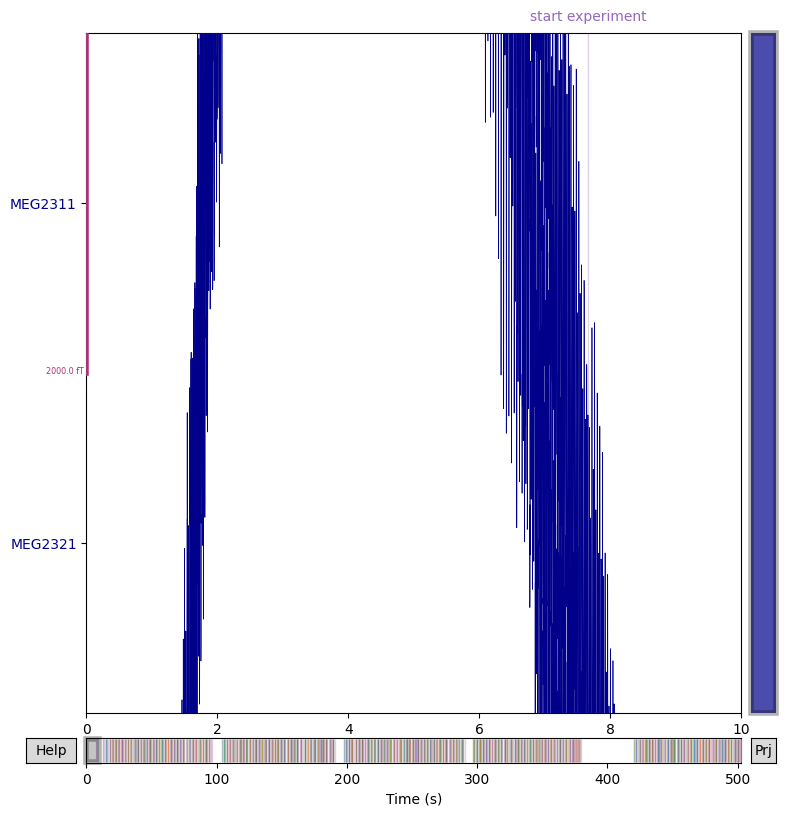

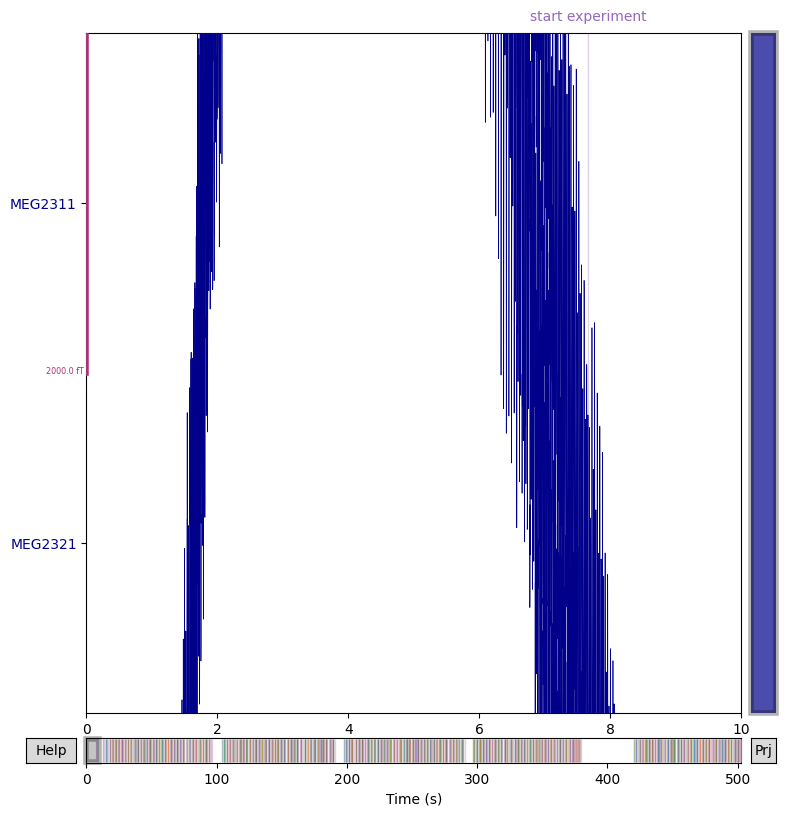

In [9]:
raw1_copy.pick(["MEG2311", "MEG2321" ])
raw1_copy.plot(proj = False)

Example for plotting powerspectra of a few sensors:

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


<ipython-input-10-6bde445fe692>:3: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  temp_psd.plot();
<ipython-input-10-6bde445fe692>:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  temp_psd.plot();


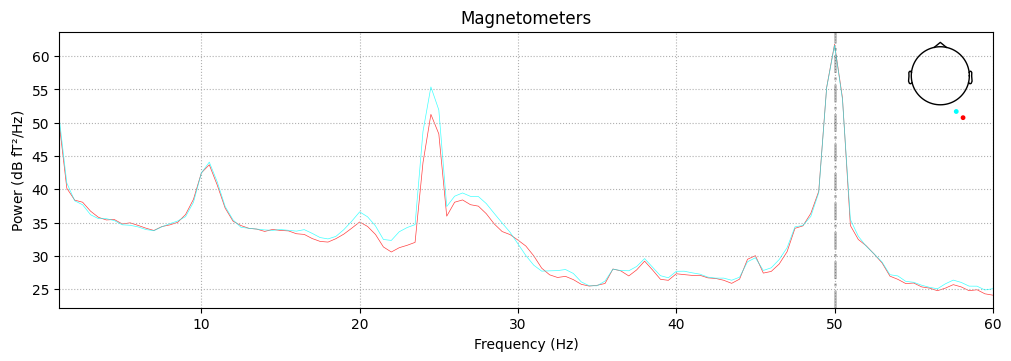

In [10]:
n_fft = 2000
temp_psd = raw1_copy.compute_psd(method="welch", fmin=1, fmax=60,  n_fft=n_fft, n_overlap=int(n_fft/2))
temp_psd.plot();

**Question 3:** What might be causing the noisy sensors and could something be done to reduce the problem for future data acquisitions?

Set the noisy and flat sensors as 'bad' in the data set:

In [11]:
raw1.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
print('bads =', raw1.info['bads'])

bads = ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']


Change MEGIN magnetometer coil types (type 3022 and 3023 to 3024) to ensure compatibility across systems.

In [12]:
raw1.fix_mag_coil_types()

102 of 102 magnetometer types replaced with T3.


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,mne_anonymize
Participant,sub-CB069
Digitized points,129 points
Good channels,"1 EOG, 12 misc, 64 EEG, 11 Internal Active Shielding data (Triux systems), 101 Magnetometers, 201 Gradiometers, 9 Stimulus, 1 System status channel information (Triux systems)"
Bad channels,"MEG2033, MEG2343, MEG2633, MEG2031"
EOG channels,EOG001
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,330.00 Hz


## Apply the Maxfilter and calibration

Apply the algorithm performing the Maxfiltering, SSS, calibration and cross-talk reduction:

In [13]:
raw1_sss = mne.preprocessing.maxwell_filter(
    raw1,
    cross_talk=crosstalk_file,
    calibration=calibration_file,
    verbose=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CB069_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.3° (max: 1.7°)
    Automatic origin fit: head of radius 79.3 mm
    Using origin 0.8, 27.6, 36.0 mm in the head frame


<ipython-input-13-7c9d02649137>:1: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw1_sss = mne.preprocessing.maxwell_filter(


        Using 84/95 harmonic components for    0.000  (69/80 in, 15/15 out)
    Using loaded raw data
    Processing 50 data chunks
[done]


Plot the power spectra of raw data:

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


<ipython-input-14-dc2eee322a4b>:2: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw1.compute_psd(fmax=60, n_fft=1000).plot();
<ipython-input-14-dc2eee322a4b>:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw1.compute_psd(fmax=60, n_fft=1000).plot();


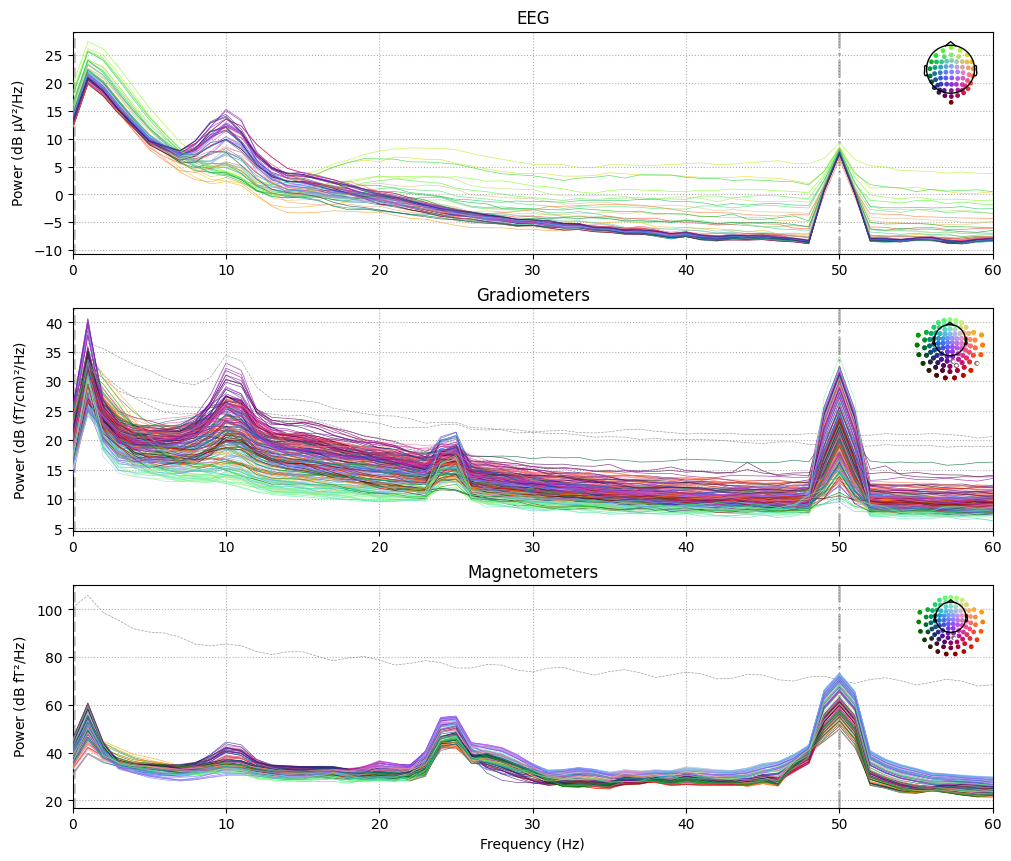

In [14]:
%matplotlib inline
raw1.compute_psd(fmax=60, n_fft=1000).plot();

and compared them to the power spectra after the application of the noise reduction algorithms:

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


<ipython-input-15-9914f35be3e4>:2: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw1_sss.compute_psd(fmax=60, n_fft=1000).plot();
<ipython-input-15-9914f35be3e4>:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw1_sss.compute_psd(fmax=60, n_fft=1000).plot();


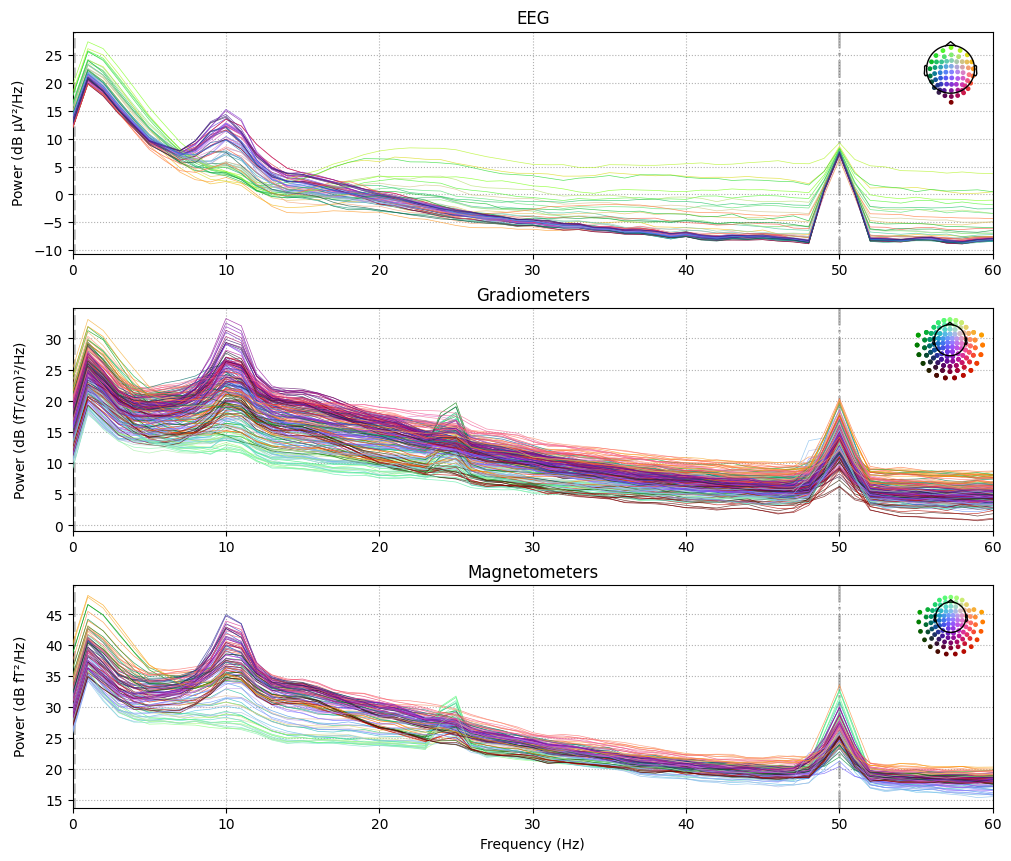

In [15]:
%matplotlib inline
raw1_sss.compute_psd(fmax=60, n_fft=1000).plot();

**Question 4:** What are the consequences of the SSS application for the 50 Hz peak of the magnetometers?

**Question 5:** Is the SSS most effective for the gradiometers or the magnetometers? Motivate the answer.

Save the result in a FIF-file:

In [16]:
raw1_sss.save(deriv_file_1, overwrite=True)

Overwriting existing file.
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_raw_sss.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_raw_sss.fif
[done]


To complete the procedure perform the noise reduction procedure for the remaining sub-file. They will be stored in the derivatives folder:

In [17]:
for subfile in range(5):
    bids_path=bids_path.update(run=f"{subfile+1:02d}")
    print(bids_path.basename)
    raw2 = read_raw_bids(bids_path=bids_path,
                          extra_params={'preload':True})
    bads = ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']
    #raw2.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
    raw2.info['bads'].extend(bads)
    raw2.fix_mag_coil_types()
    raw2_sss = mne.preprocessing.maxwell_filter(raw2,
                                                cross_talk=crosstalk_file,
                                                calibration=calibration_file)
    del raw2
    deriv_file_2=deriv_file_1.replace('run-01', f'run-{subfile+1:02d}')
    raw2_sss.save(deriv_file_2, overwrite=True)
    del raw2_sss

sub-CB069_ses-1_task-dur_run-01_meg
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_meg.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
    Range : 9000 ... 511999 =      9.000 ...   511.999 secs


<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw2 = read_raw_bids(bids_path=bids_path,


Ready.
Reading 0 ... 502999  =      0.000 ...   502.999 secs...
Reading events from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_events.tsv.
Reading channel info from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_channels.tsv.
Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info
102 of 102 magnetometer types replaced with T3.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CB069_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY


<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: Omitted 815 annotation(s) that were outside data range.
  raw2 = read_raw_bids(bids_path=bids_path,
<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: The unit for channel(s) BIO002, BIO003, MISC001, MISC002, MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC009, MISC010 has changed from V to NA.
  raw2 = read_raw_bids(bids_path=bids_path,


        Adjusted coil positions by (μ ± σ): 0.4° ± 0.3° (max: 1.7°)
    Automatic origin fit: head of radius 79.3 mm
    Using origin 0.8, 27.6, 36.0 mm in the head frame


<ipython-input-17-c2b097be6fdb>:10: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw2_sss = mne.preprocessing.maxwell_filter(raw2,


        Using 84/95 harmonic components for    0.000  (69/80 in, 15/15 out)
    Using loaded raw data
    Processing 50 data chunks
[done]
Overwriting existing file.
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_raw_sss.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_raw_sss.fif
[done]
sub-CB069_ses-1_task-dur_run-02_meg
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_meg.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated w

<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw2 = read_raw_bids(bids_path=bids_path,


Reading events from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_events.tsv.
Reading channel info from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_channels.tsv.


<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: The unit for channel(s) BIO002, BIO003, MISC001, MISC002, MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC009, MISC010 has changed from V to NA.
  raw2 = read_raw_bids(bids_path=bids_path,


Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info
102 of 102 magnetometer types replaced with T3.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CB069_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.3° (max: 1.7°)
    Automatic origin fit: head of radius 79.3 mm
    Using origin 0.8, 27.6, 36.0 mm in the head frame


<ipython-input-17-c2b097be6fdb>:10: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw2_sss = mne.preprocessing.maxwell_filter(raw2,


        Using 84/95 harmonic components for    0.000  (69/80 in, 15/15 out)
    Using loaded raw data
    Processing 80 data chunks
[done]
Overwriting existing file.
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_raw_sss.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-02_raw_sss.fif
[done]
sub-CB069_ses-1_task-dur_run-03_meg
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_meg.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated w

<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw2 = read_raw_bids(bids_path=bids_path,


Reading events from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_events.tsv.
Reading channel info from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_channels.tsv.
Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info
102 of 102 magnetometer types replaced with T3.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CB069_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY


<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: The unit for channel(s) BIO002, BIO003, MISC001, MISC002, MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC009, MISC010 has changed from V to NA.
  raw2 = read_raw_bids(bids_path=bids_path,


        Adjusted coil positions by (μ ± σ): 0.4° ± 0.3° (max: 1.7°)
    Automatic origin fit: head of radius 79.3 mm
    Using origin 0.8, 27.6, 36.0 mm in the head frame


<ipython-input-17-c2b097be6fdb>:10: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw2_sss = mne.preprocessing.maxwell_filter(raw2,


        Using 84/95 harmonic components for    0.000  (69/80 in, 15/15 out)
    Using loaded raw data
    Processing 80 data chunks
[done]
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_raw_sss.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-03_raw_sss.fif
[done]
sub-CB069_ses-1_task-dur_run-04_meg
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_meg.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)

<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw2 = read_raw_bids(bids_path=bids_path,


Reading events from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_events.tsv.
Reading channel info from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_channels.tsv.


<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: The unit for channel(s) BIO002, BIO003, MISC001, MISC002, MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC009, MISC010 has changed from V to NA.
  raw2 = read_raw_bids(bids_path=bids_path,


Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info
102 of 102 magnetometer types replaced with T3.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CB069_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.3° (max: 1.7°)
    Automatic origin fit: head of radius 79.3 mm
    Using origin 0.8, 27.6, 36.0 mm in the head frame


<ipython-input-17-c2b097be6fdb>:10: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw2_sss = mne.preprocessing.maxwell_filter(raw2,


        Using 84/95 harmonic components for    0.000  (69/80 in, 15/15 out)
    Using loaded raw data
    Processing 80 data chunks
[done]
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_raw_sss.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-04_raw_sss.fif
[done]
sub-CB069_ses-1_task-dur_run-05_meg
Opening raw data file drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_meg.fif...
    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)  idle
        generated with autossp-1.0.1 (1 x 306)

<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw2 = read_raw_bids(bids_path=bids_path,


Reading events from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_events.tsv.
Reading channel info from drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_channels.tsv.
Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info
102 of 102 magnetometer types replaced with T3.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2033', 'MEG2343', 'MEG2633', 'MEG2031']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CB069_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY


<ipython-input-17-c2b097be6fdb>:4: RuntimeWarning: The unit for channel(s) BIO002, BIO003, MISC001, MISC002, MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC009, MISC010 has changed from V to NA.
  raw2 = read_raw_bids(bids_path=bids_path,


        Adjusted coil positions by (μ ± σ): 0.4° ± 0.3° (max: 1.7°)
    Automatic origin fit: head of radius 79.3 mm
    Using origin 0.8, 27.6, 36.0 mm in the head frame


<ipython-input-17-c2b097be6fdb>:10: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  raw2_sss = mne.preprocessing.maxwell_filter(raw2,


        Using 83/95 harmonic components for    0.000  (68/80 in, 15/15 out)
    Using loaded raw data
    Processing 77 data chunks
[done]
Writing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_raw_sss.fif
Closing /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/preprocessing/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-05_raw_sss.fif
[done]




## When and when not to apply SSS

The SSS algorithm serves to suppress external noise sources; however, there are also some disadvantages. One issue is that SSS dramatically reduces the rank of the data. This is important to take into account when performing source modeling when the covarience matrix is of importance, e.g. beamforming approaches. A second issue is that broad-band noise on the data might increase. This is not a problem per se when investigating event-related fields and modulations of oscillations below 30 Hz. However, the SSS-related broad-band noise increase might present a problem when performing multi-variate pattern analysis (see Bezudnova et al., in press). When planning to perform multi-variate pattern or representational pattern analysis, it is recommended to use signal space projection or homogeneous field correction rather than SSS.



## Preregistration and publication

Preregistration: Report the sampling frequency and the properties of the anti-aliasing lowpass filter. Also report the peripheral data to be recorded (e.g. the EOG and ECG)

Publication, example:

"Sensors with excessive artefacts were marked from the data sets using a semi-automatic detection algorithm (about 8 per participant). Subsequently, the Signal-Space Separation (SSS) method  (Taulu et al., 2004) was applied to reduce environmental artefacts. SSS decomposes the data using multiple moments based on spherical harmonics and removes the component of the magnetic field originating from outside the MEG helmet."

## References

Bezsudnova, Y., Quinn, A., and Jensen, O. (in press) Optimizing magnetometers arrays and analysis pipelines for multivariate pattern analysis. 	J Neurosci Methods

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616

Taulu,S. and Kajola, M. (2005) Presentation of electromagnetic multichannel data: the signal space separation method. Journal of Applied Physics, 97(12):124905 doi:10.1063/1.1935742.

Taulu, S. and Simola, J. (2006) Spatiotemporal signal space separation method for rejecting nearby interference in MEG measurements. Physics in Medicine and Biology, 51(7):1759–1768 doi:10.1088/0031-9155/51/7/008.